In [1]:
import time
start_time = time.perf_counter()

In [2]:
%matplotlib inline
# version check
import numpy
print('The numpy version is {}.'.format(numpy.__version__))
import pandas
print('The pandas version is {}.'.format(pandas.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import matplotlib
print('The matplotlib version is {}.'.format(matplotlib.__version__))
import regex
print('The regex version is {}.'.format(regex.__version__))

The numpy version is 1.18.1.
The pandas version is 1.0.4.
The scikit-learn version is 0.23.1.
The matplotlib version is 3.2.1.
The regex version is 2.5.80.


In [3]:
# set random state for reproducibility
random_state = 42

# default numpy settings
import numpy as np
np.set_printoptions(edgeitems=3)
np.core.arrayprint._line_width = 80

# update settings
import numpy as np
np.set_printoptions(edgeitems=15, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# update pandas settings
import pandas as pd
pd.set_option('max_colwidth', 200)
pd.options.display.max_rows = 250

## Import data

In [4]:
%%time
Dataset_directory = './data/enron/clean_clean_outliers.csv'
df = pd.read_csv(Dataset_directory, index_col=0)

Wall time: 5.7 s


In [5]:
df.head(1)

,f_dir,m_id,m_date,m_from,m_to,m_cc,m_bcc,m_subj,mime_vers,cont_type,...,x_fname,o_body,m_body,gender,n_emails_sent,n_characters_start,clean_char,n_char,clean_body,preprocessed_body
0,./data/enron/maildir/dasovich-j/all_documents/10019,<30982749.1075843392750.JavaMail.evans@thyme>,"Thu, 15 Mar 2001 04:37:00 -0800 (PST)",alan.comnes@enron.com,"james.steffes@enron.com, jeff.dasovich@enron.com, sandra.mccubbin@enron.com",NaN,NaN,Per today's call,1.0,text/plain; charset=us-ascii,...,jdasovic.nsf\n\n,"Message-ID: <30982749.1075843392750.JavaMail.evans@thyme>\nDate: Thu, 15 Mar 2001 04:37:00 -0800 (PST)\nFrom: alan.comnes@enron.com\nTo: james.steffes@enron.com, jeff.dasovich@enron.com, sandra.mc...",My recollection is that this sheet is a bit vague on detail.\n\nCalifornia's gas problems are twofold:\n\nWellhead prices are still high. CERA is the best place to get more data on \ndrilling act...,0.0,645,360,233,360,My recollection is that this sheet is a bit vague on detail.\n\nCalifornia's gas problems are twofold:\n\nWellhead prices are still high. CERA is the best place to get more data on \ndrilling act...,recollection sheet bit vague detail california gas problem twofold wellhead price still high cera get data drilling activity etc instate capacity tigh pg sdg cec study event california utiilties p...


In [6]:
df.tail(1)

,f_dir,m_id,m_date,m_from,m_to,m_cc,m_bcc,m_subj,mime_vers,cont_type,...,x_fname,o_body,m_body,gender,n_emails_sent,n_characters_start,clean_char,n_char,clean_body,preprocessed_body
138261,./data/enron/maildir/nemec-g/sent_items/429,<17349131.1075858555679.JavaMail.evans@thyme>,"Tue, 17 Jul 2001 15:32:56 -0700 (PDT)",gerald.nemec@enron.com,chris.hilgert@enron.com,"Bennett, Peter",NaN,RE: Confidentiality Agreement,1.0,text/plain; charset=us-ascii,...,"Nemec, Gerald (Non-Privileged).pst\n\n","Message-ID: <17349131.1075858555679.JavaMail.evans@thyme>\nDate: Tue, 17 Jul 2001 15:32:56 -0700 (PDT)\nFrom: gerald.nemec@enron.com\nTo: chris.hilgert@enron.com\nSubject: RE: Confidentiality Agre...",Two things; 1. The modification excludes all oral information. So any confidential information that you guys orally give them is not protected. 2. It might be a headache for you guys to remembe...,0.0,3888,1703,181,312,Two things; 1. The modification excludes all oral information. So any confidential information that you guys orally give them is not protected. 2. It might be a headache for you guys to remembe...,two thing modification excludes information confidential information guy orally give protected might headache guy remember everything confidential forget protected think change come


In [7]:
# global variable for the series containing the corpus, target 
Corpus_series = 'preprocessed_body'
Target_series = 'gender'

## Monitoring impact on labels
We want to keep an eye on the male/female ratio when filtering out our dataset (especially when blanket removing things like 'duplicates', where the filtering can be applied to either label for the same condition) so that our label ratio isn't significantly unbalanced as a result.

In [8]:
def monitor_label(df):
    b = df.groupby([Target_series]).size()[0]
    g = df.groupby([Target_series]).size()[1]
    print('Frame Size: {} observations\nboy: {}\ngirl: {}\nB/G Ratio: {:.3f} ({:.0f}%, {:.0f}%)'.format(len(df), b, g, b/g, b*100/(b+g), g*100/(b+g)))
    
monitor_label(df)

Frame Size: 138262 observations
boy: 76597
girl: 61665
B/G Ratio: 1.242 (55%, 45%)


## Checking for NaN, duplicates in dataset

In [9]:
df = df[df[Target_series].notna()] # NaN on target variable
_ = df[df[Corpus_series].isna()].index # NaN on corpus
df = df.drop(_)
df = df.drop_duplicates(Corpus_series) # Duplicates on corpus

monitor_label(df)

Frame Size: 138262 observations
boy: 76597
girl: 61665
B/G Ratio: 1.242 (55%, 45%)


## Randomize dataframe

In [10]:
def resample_frame(df, n=None, random_state=random_state):
    """Randomizes dataframe, then resets the index.
    If a subset of dataset is desired, pass a number of subsets to n parameter"""

    if n is None:
        df = df.sample(n=len(df), random_state=random_state).reset_index(drop=True)
    elif n is not None:
        df = df.sample(n=n, random_state=random_state).reset_index(drop=True)
    return df

df = resample_frame(df, n=len(df)) # resampled

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138262 entries, 0 to 138261
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   f_dir               138262 non-null  object 
 1   m_id                138262 non-null  object 
 2   m_date              138262 non-null  object 
 3   m_from              138262 non-null  object 
 4   m_to                136003 non-null  object 
 5   m_cc                44558 non-null   object 
 6   m_bcc               42520 non-null   object 
 7   m_subj              132469 non-null  object 
 8   mime_vers           138262 non-null  float64
 9   cont_type           138262 non-null  object 
 10  encode              138262 non-null  object 
 11  x_from              138262 non-null  object 
 12  x_to                136579 non-null  object 
 13  x_cc                42818 non-null   object 
 14  x_bcc               116 non-null     object 
 15  x_fold              138262 non-nul

## Model

In [12]:
import regex as re
def visualizer(df, n=1000, list_n=30, max_iter=100, n_jobs=None, min_df=1, max_df=1.0, token_pattern=r"\w{2,}", stop_words=None, random_state=random_state):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib import rcParams
    sns.set_style("whitegrid")
    sns.set_context("notebook")
    import regex as re

    def plot_ecdf(x, xlab='', ylab='', title='', logx=False, logy=False, hline=None, vline=None):
        x = np.sort(x)
        n = x.size
        y = np.arange(1, n+1) / n
        plt.scatter(x, y, color='g')
        plt.xlabel(xlab, fontsize=14)
        plt.ylabel(ylab, fontsize=14)
        plt.title(title)
        if logx == True:
            plt.xscale('log')
        if logy == True:
            plt.yscale('log')
        if hline is not None:
            plt.axhline(hline, color='r', linestyle='--')
        if vline is not None:
            plt.axvline(vline, color='r', linestyle='--')

        
    def plot_scatter(x, y, xlab='', ylab='', title='', logx=False, logy=False, hline=None, vline=None):
        plt.scatter(x, y, alpha=0.25)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(title)
        if logx == True:
            plt.xscale('log')
        if logy == True:
            plt.yscale('log')
        if hline is not None:
            plt.axhline(hline, color='r', linestyle='--')
        if vline is not None:
            plt.axvline(vline, color='r', linestyle='--')
            
    def plot_2_4(_, suptitle='', hline=None, vline=None):
        plt.figure(figsize=(20,10))
        
        plt.subplot(2, 4, 1)
        _.plot(kind='hist', bins=20, title='linx, liny', logx=False, logy=False)
        plt.subplot(2, 4, 2)
        _.plot(kind='hist', bins=20, title='linx, logy', logx=False, logy=True)
        plt.subplot(2, 4, 3)
        plot_ecdf(_, xlab='', ylab='', title='linx, liny', logx=False, logy=False, hline=None, vline=None)
        plt.subplot(2, 4, 4)
        plot_ecdf(_, xlab='', ylab='', title='linx, logy', logx=False, logy=True, hline=None, vline=None)
        plt.subplot(2, 4, 5)
        _.plot(kind='hist', bins=20, title='logx, liny', logx=True, logy=False)
        plt.subplot(2, 4, 6)
        _.plot(kind='hist', bins=20, title='logx, logy', logx=True, logy=True)
        plt.subplot(2, 4, 7)
        plot_ecdf(_, xlab='', ylab='', title='logx, liny', logx=True, logy=False, hline=None, vline=None)
        plt.subplot(2, 4, 8)
        plot_ecdf(_, xlab='', ylab='', title='logx, logy', logx=True, logy=True, hline=None, vline=None)
        
        plt.suptitle(suptitle, fontsize=16)
        plt.show()     
        
    def plot_2_2(x, y, suptitle='', hline=None, vline=None):
        plt.figure(figsize=(10,10))
        
        plt.subplot(2, 2, 1)
        plot_scatter(x, y, xlab='', ylab='', title='linx, liny', logx=False, logy=False, hline=None, vline=None)
        plt.subplot(2, 2, 2)
        plot_scatter(x, y, xlab='', ylab='', title='linx, logy', logx=False, logy=True, hline=None, vline=None)
        plt.subplot(2, 2, 3)
        plot_scatter(x, y, xlab='', ylab='', title='linx, liny', logx=True, logy=False, hline=None, vline=None)
        plt.subplot(2, 2, 4)
        plot_scatter(x, y, xlab='', ylab='', title='linx, logy', logx=True, logy=True, hline=None, vline=None)
        
        plt.suptitle(suptitle, fontsize=16)
        plt.show()  
    
    # CREATE SAMPLE SUBSET
    X = df[Corpus_series].values[:n]
    y = df[Target_series].values[:n]

    # FIT, TRANSFORM VECTORIZER
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import CountVectorizer
    #vect = TfidfVectorizer(use_idf=False)
    vect = CountVectorizer(min_df=min_df, max_df=max_df, token_pattern=token_pattern, stop_words=stop_words)
    X = vect.fit_transform(X)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state) 

    # FIT, TRANSFORM MODEL
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(solver='liblinear', random_state=random_state).fit(X_train, y_train)
    model_name = model.__class__.__name__

    # GET DATA
    fn = vect.get_feature_names() 
    fi = model.coef_[0] # get importance values from model output
    fc = X.toarray() # creates feature count matrix from CountVectorizer fit_transform object
    fc = np.sum(fc, 0) # sums the counts along the 0 axis (column) to produce word count
    _ = pd.DataFrame(zip(fn, fi, fc))
    _.columns = ['feature_name', 'feature_coef', 'feature_frequency']
    _['character_count'] = _.feature_name.str.count('[A-aZ-z]')

    
    
    # VISUALIZE
    plot_2_4(_.feature_coef, suptitle='Feature Coefficients\nHistogram, ECDF Plot', hline=None, vline=None)
    print(_.feature_coef.describe())
    
    plot_2_4(_.feature_frequency, suptitle='Feature Frequency\nHistogram, ECDF Plot', hline=None, vline=None)
    print(_.feature_frequency.describe())
    
    plot_2_4(_.character_count, suptitle='Character Count\nHistogram, ECDF Plot', hline=None, vline=None)
    print(_.character_count.describe())  
    
    plot_2_2(_.feature_coef, _.feature_frequency, suptitle='Coefficient v. Frequency', hline=None, vline=None)
    
    plot_2_2(_.feature_coef, _.character_count, suptitle='Coefficient v. Character Count', hline=None, vline=None)
    print(_.describe())  
    print()
    
    _ = _.sort_values('feature_coef', ascending=False)
    # plot lower feature importance
    plt.figure(figsize=(16,14)) # longer plot for word list
    plt.subplot(1, 2, 1)
    plt.plot(_.feature_coef[:-(list_n+1):-1].values, [x for x in range(len(_.feature_coef[:-(list_n+1):-1].values))], color='r') # values to xaxis
    plt.yticks(range(len(_.feature_name[:-(list_n+1):-1])), _.feature_name[:-(list_n+1):-1], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Lowest %d Feature Importance' % (model_name, list_n), fontsize=16)
    
    # plot upper feature importance
    plt.subplot(1, 2, 2)
    plt.plot(_.feature_coef[:list_n].values, [x for x in range(len(_.feature_coef[:list_n].values))]) # values to xaxis
    plt.yticks(range(len(_.feature_name[:list_n])), _.feature_name[:list_n], fontsize=14) # labels to y-axis
    plt.ylim(list_n-1,0) # flip y-axis to descending
    plt.title('%s: Highest %d Feature Importance' % (model_name, list_n), fontsize=16)
    plt.show()    

    print()
    print(_[:list_n])
    print()
    print(_[:-(list_n+1):-1])
    print()
    
    # SCORE
    y_pred = model.predict(X_test)
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred))
    from sklearn.metrics import plot_roc_curve
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.title('ROC Curve')
    plot_roc_curve(model, X_test, y_test, ax=ax)
    plt.show()

## Initial Observations

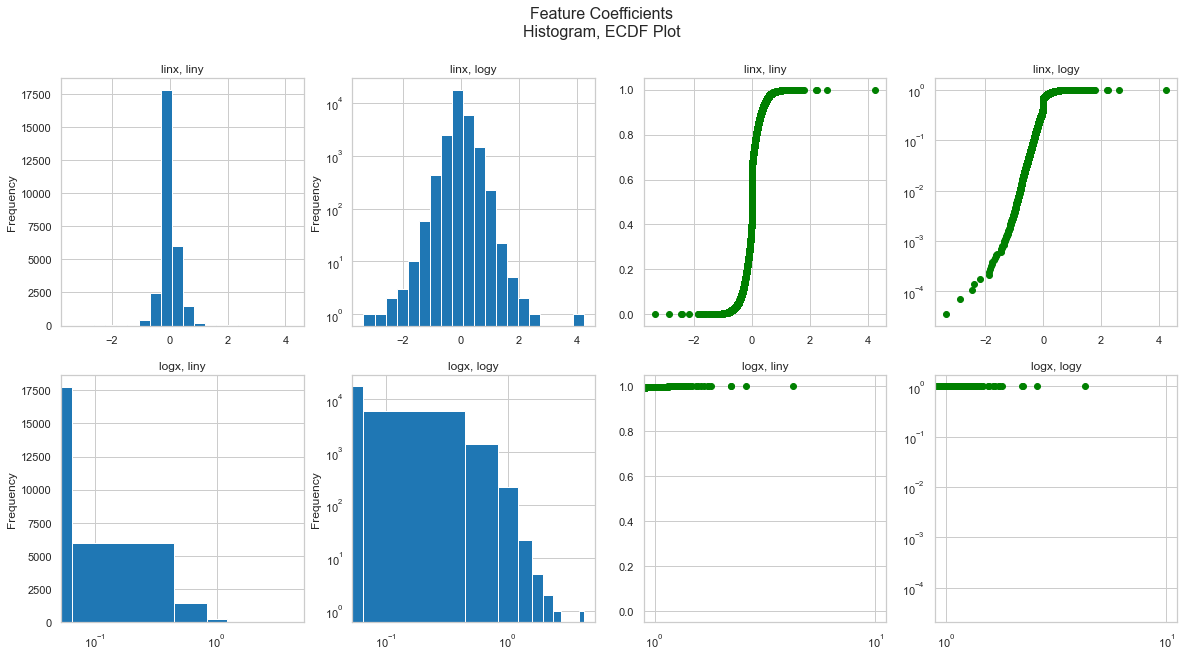

count    28474.000000
mean        -0.009206
std          0.286471
min         -3.365496
25%         -0.120795
50%          0.000000
75%          0.085635
max          4.257436
Name: feature_coef, dtype: float64


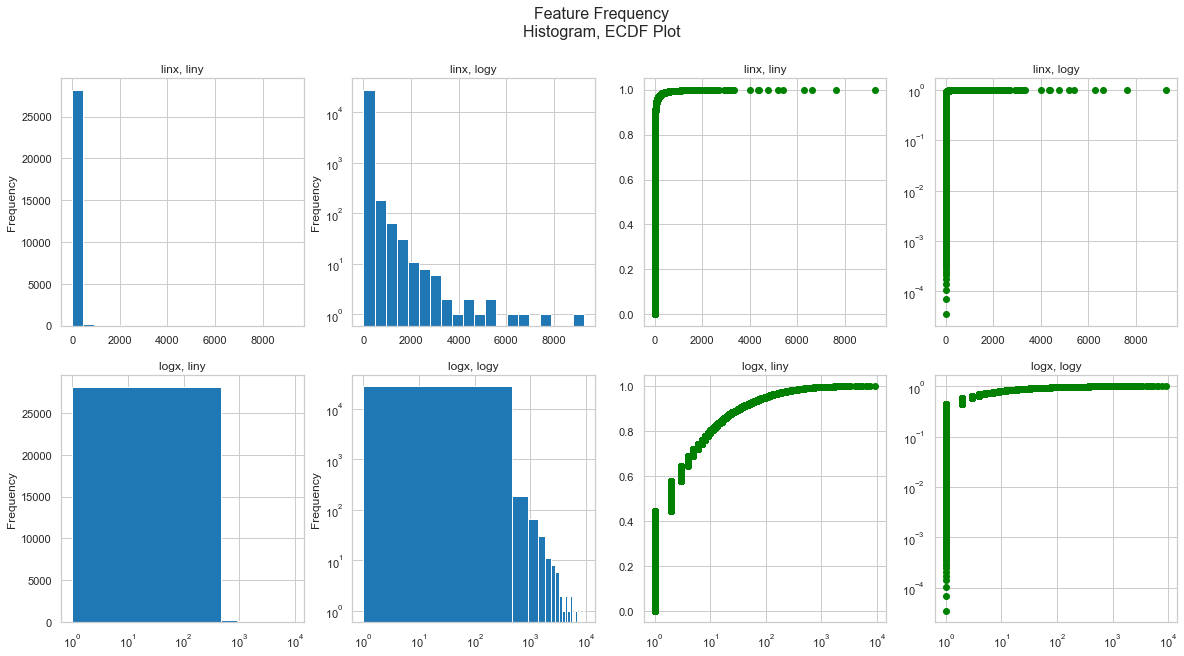

count    28474.000000
mean        27.388319
std        169.486133
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       9272.000000
Name: feature_frequency, dtype: float64


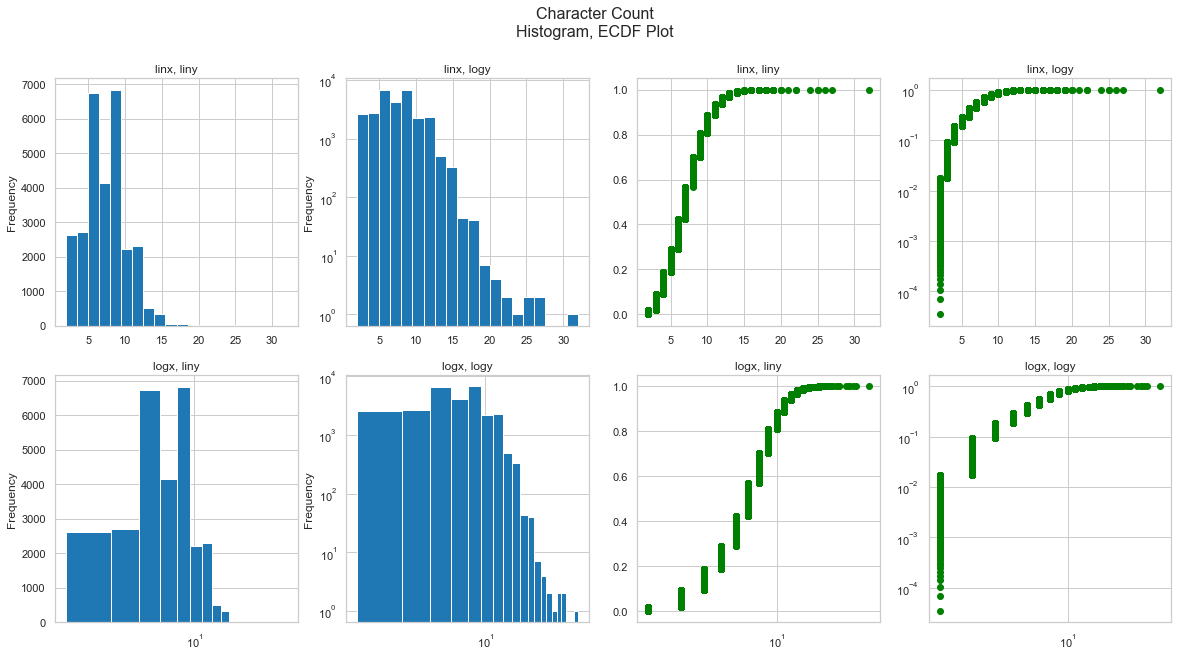

count    28474.000000
mean         7.152630
std          2.743835
min          2.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         32.000000
Name: character_count, dtype: float64


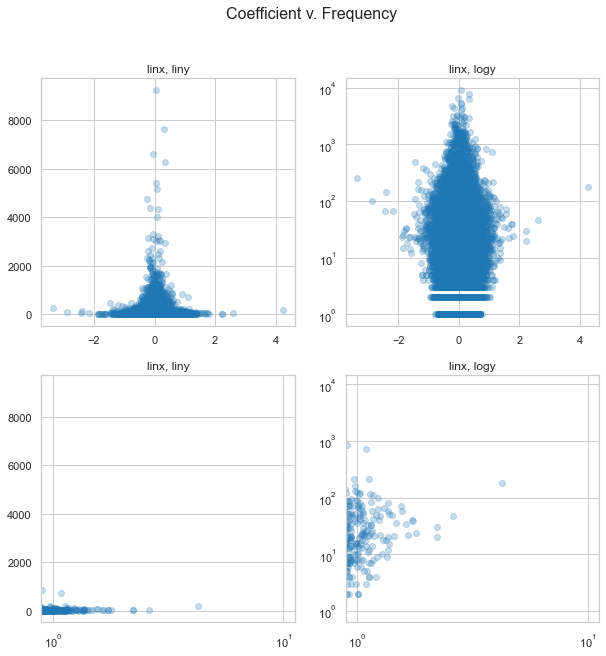

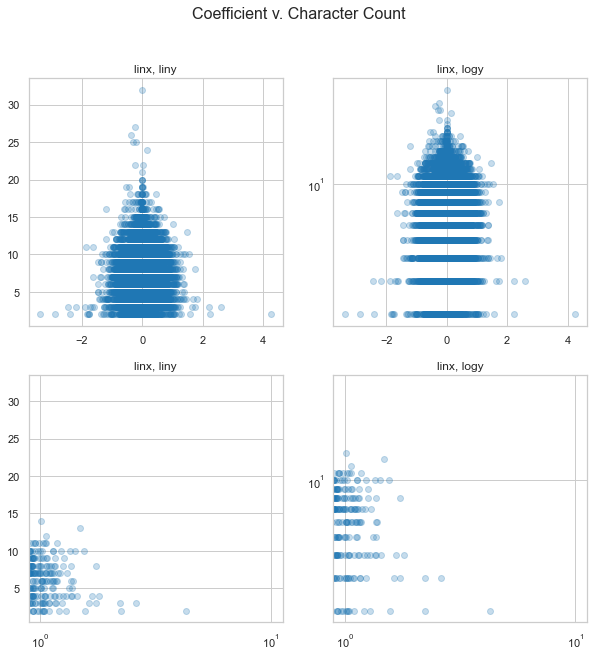

       feature_coef  feature_frequency  character_count
count  28474.000000       28474.000000     28474.000000
mean      -0.009206          27.388319         7.152630
std        0.286471         169.486133         2.743835
min       -3.365496           1.000000         2.000000
25%       -0.120795           1.000000         5.000000
50%        0.000000           2.000000         7.000000
75%        0.085635           7.000000         9.000000
max        4.257436        9272.000000        32.000000



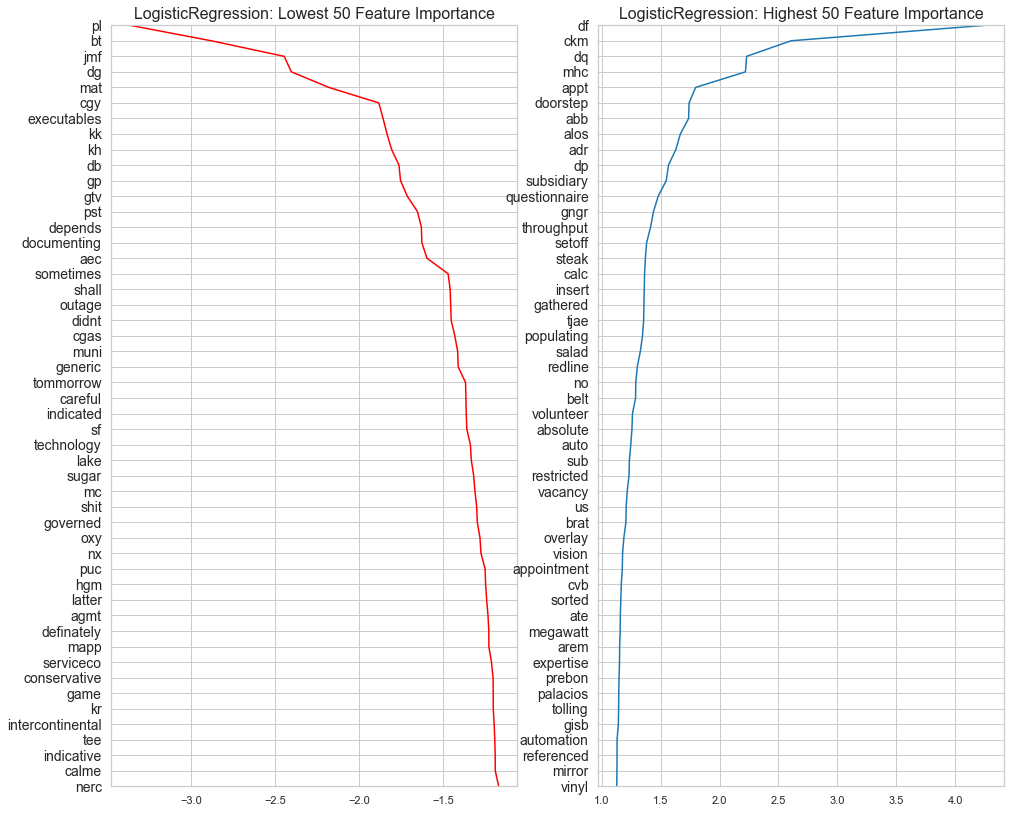


        feature_name  feature_coef  feature_frequency  character_count
6780              df      4.257436                179                2
4325             ckm      2.606287                 47                3
7464              dq      2.229836                 20                2
15645            mhc      2.219864                 30                3
1294            appt      1.797386                 24                4
7376        doorstep      1.741485                 39                8
17               abb      1.737722                 40                3
826             alos      1.667401                 22                4
426              adr      1.629356                 34                3
7448              dp      1.566950                 59                2
24346     subsidiary      1.548150                 72               10
20145  questionnaire      1.479891                 35               13
10664           gngr      1.439534                 21                4
25417

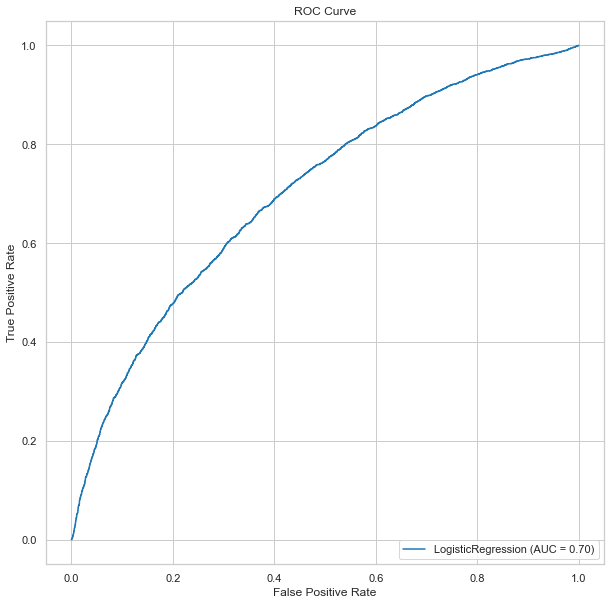

Wall time: 22.2 s


In [13]:
%%time
visualizer(df, n=30000, list_n=50, max_iter=1000, n_jobs=-1, min_df=1, max_df=1.0, token_pattern=r"\w{2,}", stop_words=None)

## First Adjustment: Word Count (7ct-60%), Character Count(3-13)

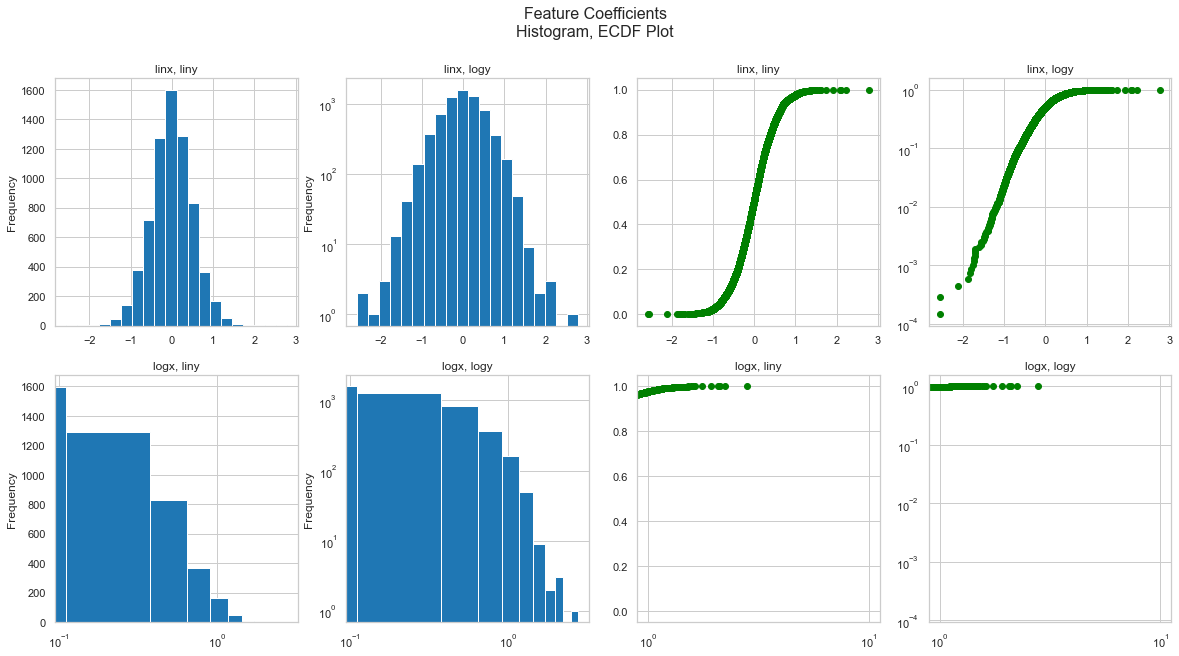

count    6878.000000
mean       -0.011069
std         0.493719
min        -2.560905
25%        -0.320717
50%        -0.008210
75%         0.303140
max         2.782829
Name: feature_coef, dtype: float64


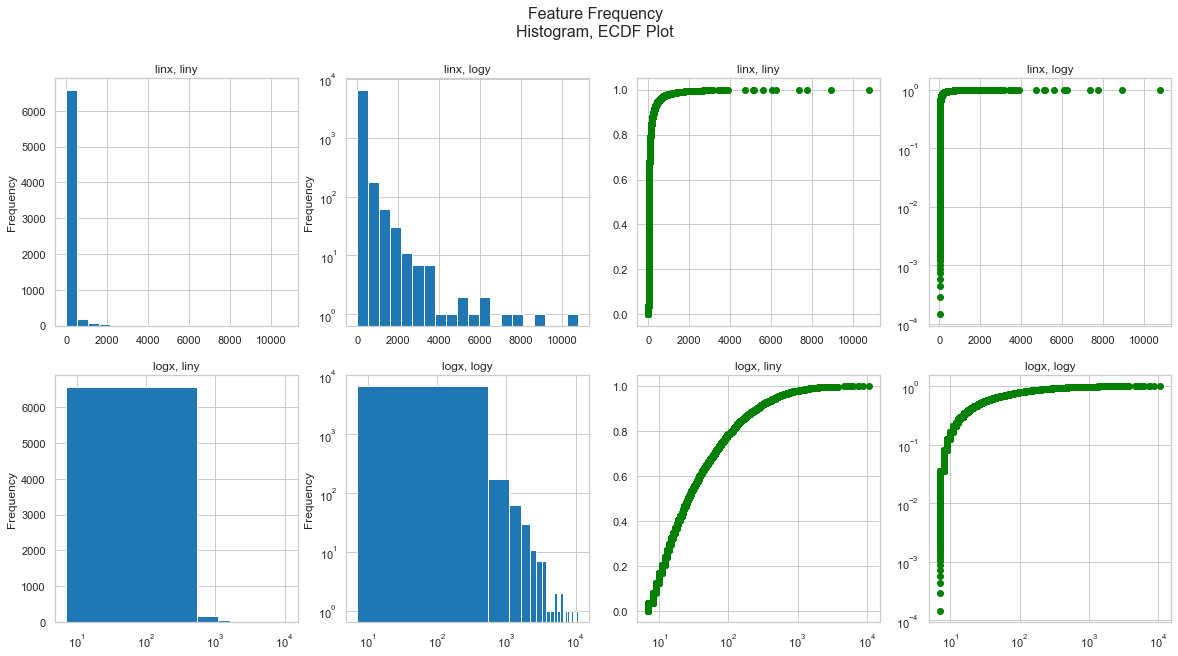

count     6878.000000
mean       120.816807
std        384.864133
min          7.000000
25%         13.000000
50%         26.000000
75%         82.000000
max      10783.000000
Name: feature_frequency, dtype: float64


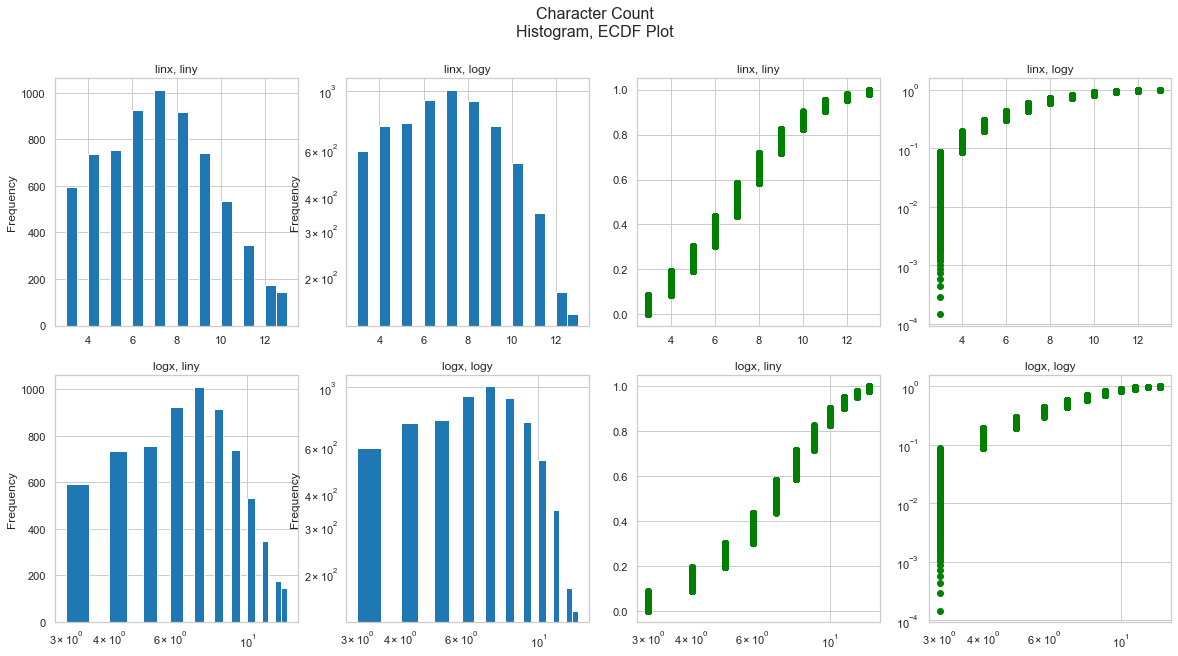

count    6878.000000
mean        7.017592
std         2.526833
min         3.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        13.000000
Name: character_count, dtype: float64


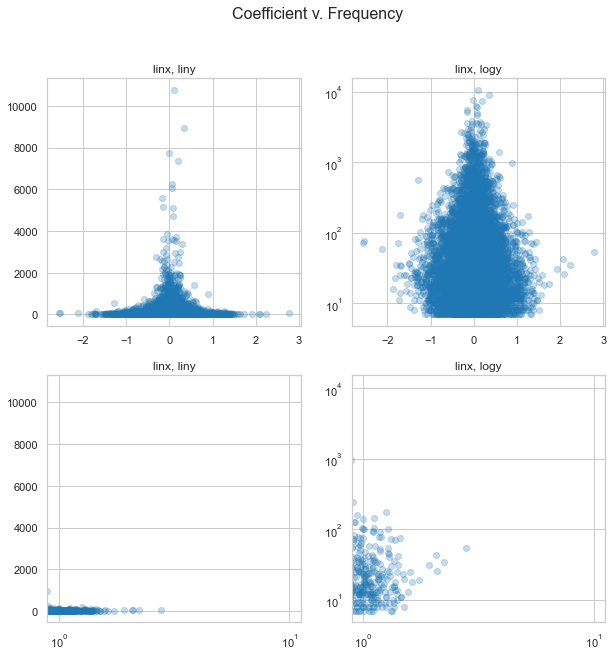

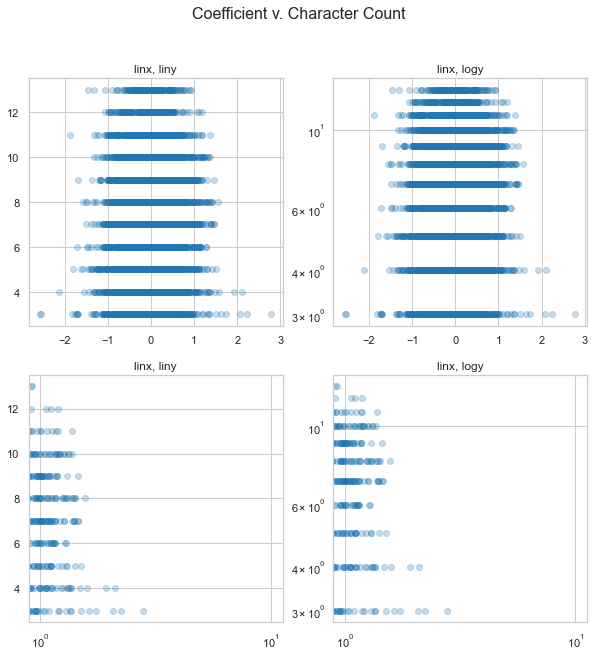

       feature_coef  feature_frequency  character_count
count   6878.000000        6878.000000      6878.000000
mean      -0.011069         120.816807         7.017592
std        0.493719         384.864133         2.526833
min       -2.560905           7.000000         3.000000
25%       -0.320717          13.000000         5.000000
50%       -0.008210          26.000000         7.000000
75%        0.303140          82.000000         9.000000
max        2.782829       10783.000000        13.000000



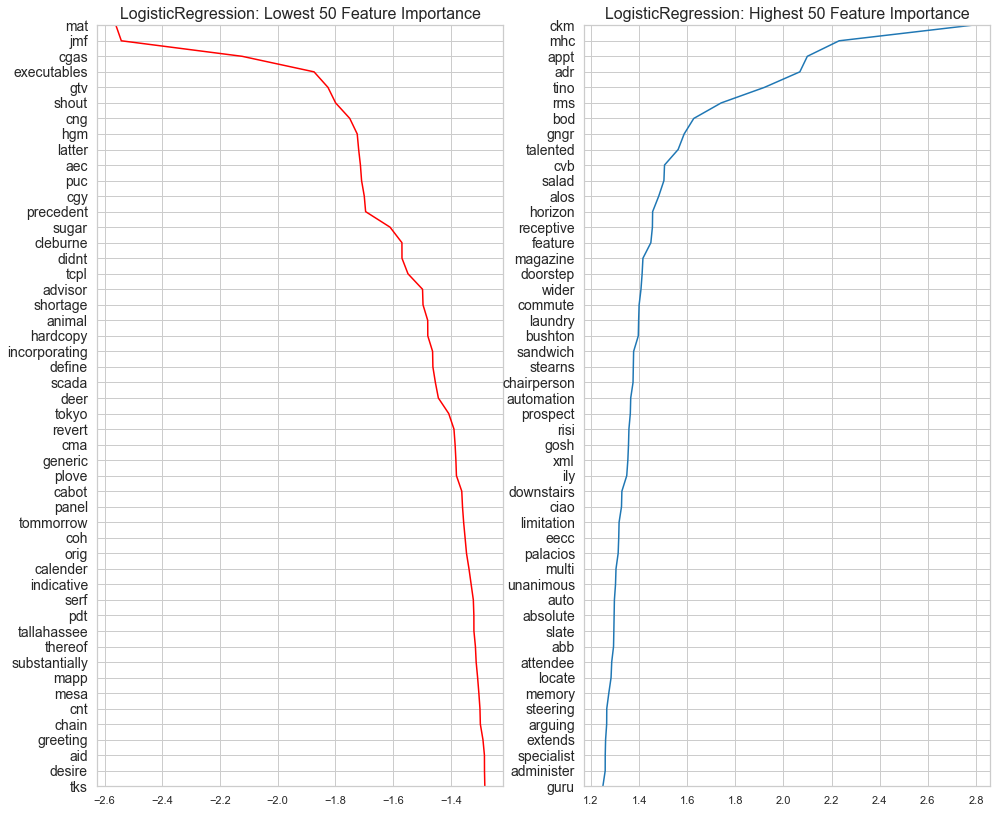


     feature_name  feature_coef  feature_frequency  character_count
1075          ckm      2.782829                 54                3
3829          mhc      2.231569                 35                3
372          appt      2.099367                 26                4
119           adr      2.068282                 43                3
6262         tino      1.921104                 31                4
5358          rms      1.741359                 19                3
713           bod      1.627470                 18                3
2748         gngr      1.587551                 25                4
6086     talented      1.562603                 13                8
1573          cvb      1.506041                  8                3
5417        salad      1.503549                 20                5
230          alos      1.482029                 23                4
2972      horizon      1.456624                 11                7
5015    receptive      1.455689                

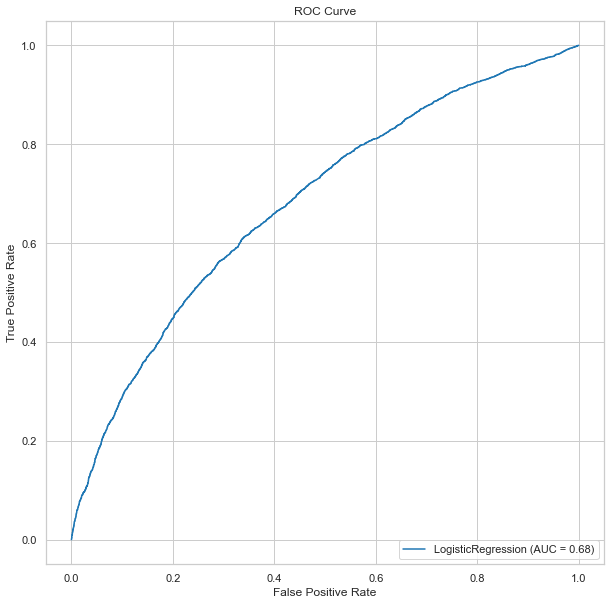

Wall time: 18.6 s


In [14]:
%%time
visualizer(df, n=35000, list_n=50, max_iter=1000, n_jobs=-1, min_df=7, max_df=0.6, token_pattern=r"\w{3,13}", stop_words=None)

## Second Adjustment: Word Count (50ct-50%), Character Count(5-11)

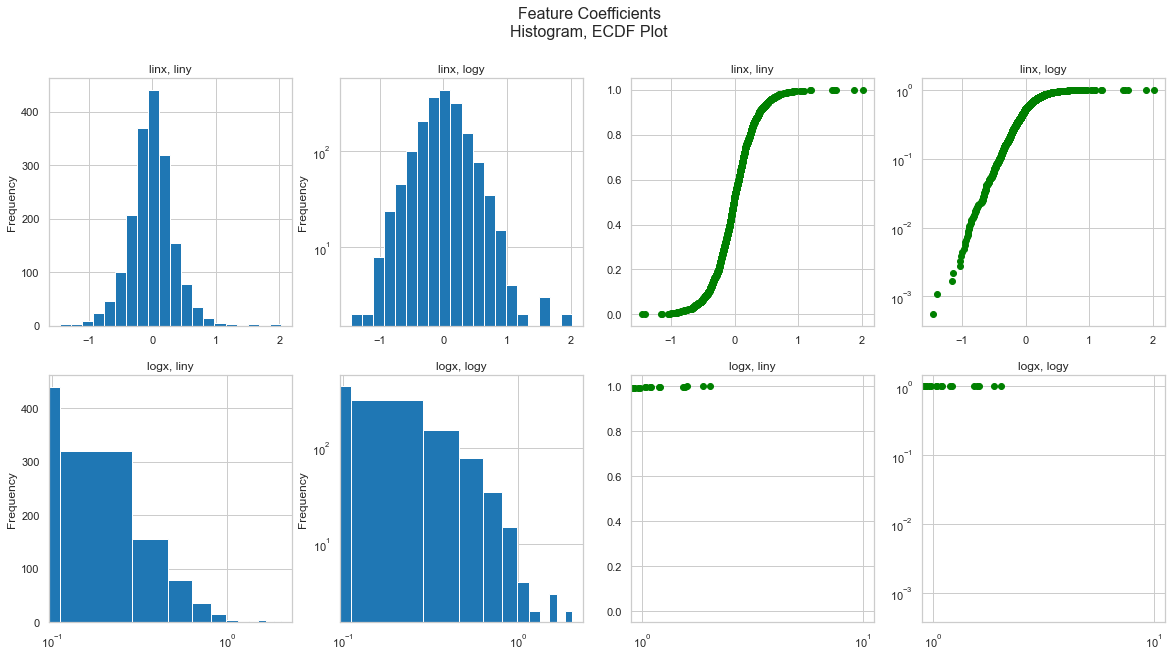

count    1812.000000
mean       -0.006300
std         0.342444
min        -1.448862
25%        -0.206958
50%        -0.012711
75%         0.183695
max         2.018544
Name: feature_coef, dtype: float64


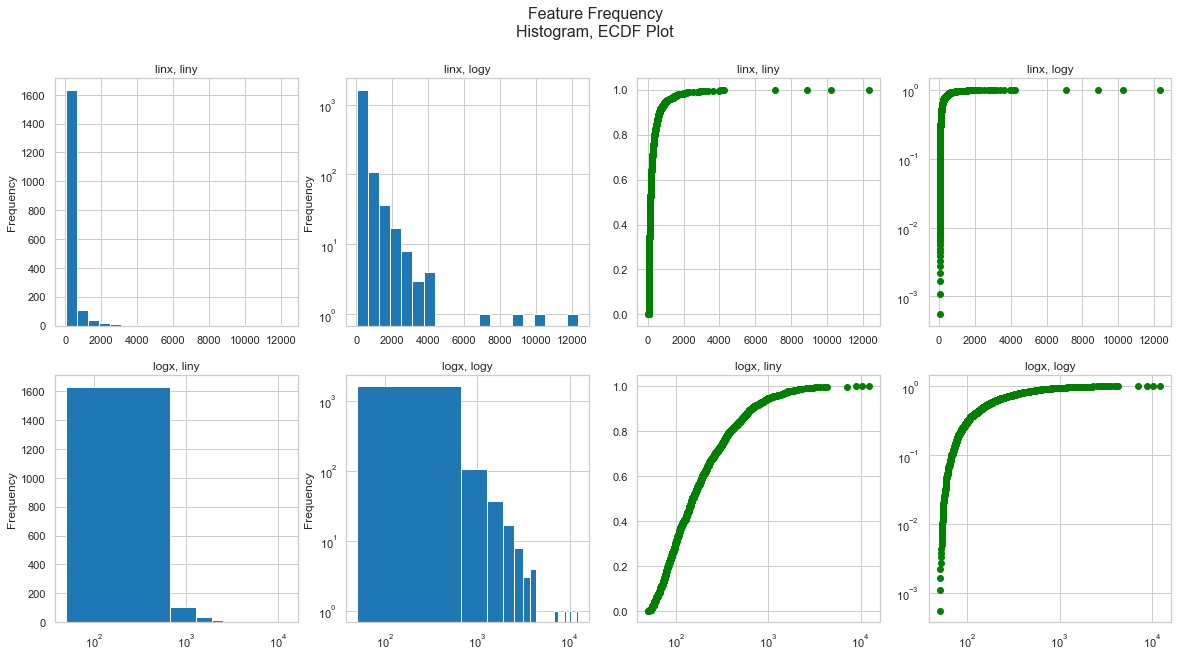

count     1812.000000
mean       321.586093
std        623.044125
min         50.000000
25%         89.000000
50%        150.000000
75%        324.000000
max      12325.000000
Name: feature_frequency, dtype: float64


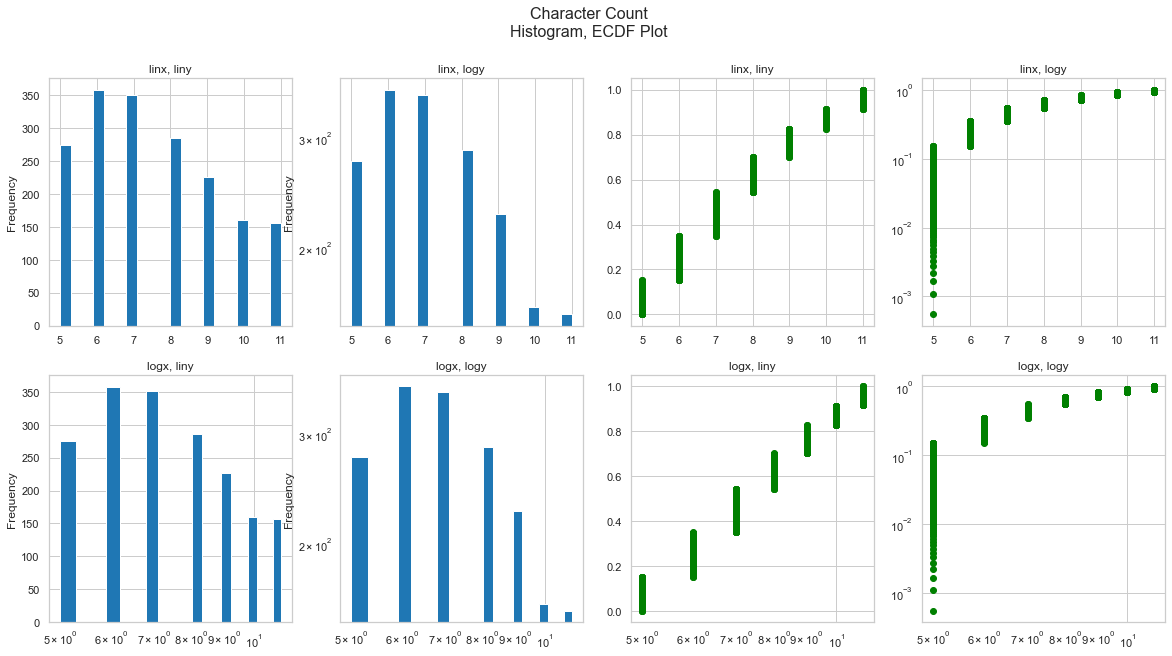

count    1812.000000
mean        7.515453
std         1.835680
min         5.000000
25%         6.000000
50%         7.000000
75%         9.000000
max        11.000000
Name: character_count, dtype: float64


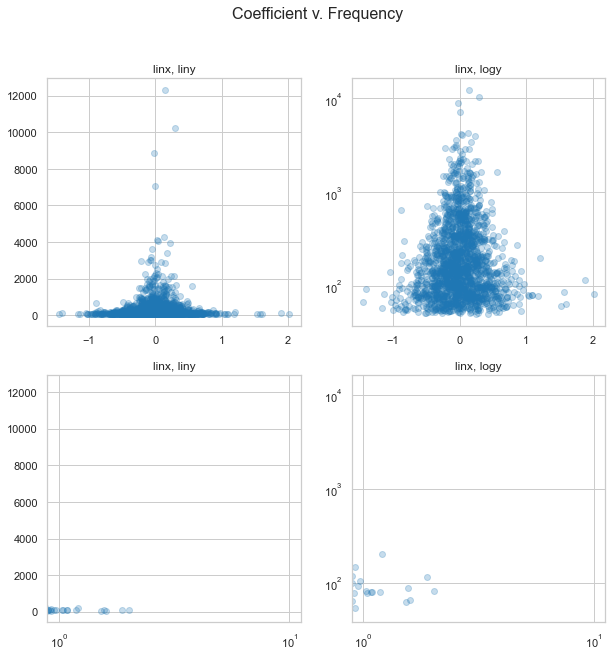

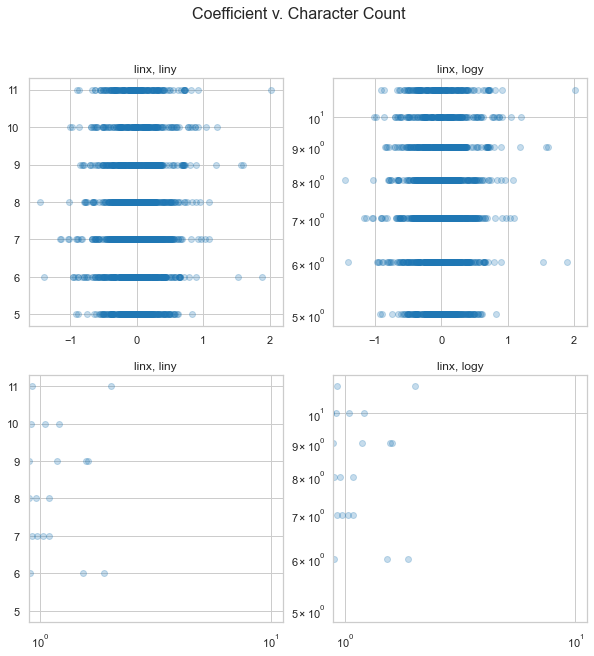

       feature_coef  feature_frequency  character_count
count   1812.000000        1812.000000      1812.000000
mean      -0.006300         321.586093         7.515453
std        0.342444         623.044125         1.835680
min       -1.448862          50.000000         5.000000
25%       -0.206958          89.000000         6.000000
50%       -0.012711         150.000000         7.000000
75%        0.183695         324.000000         9.000000
max        2.018544       12325.000000        11.000000



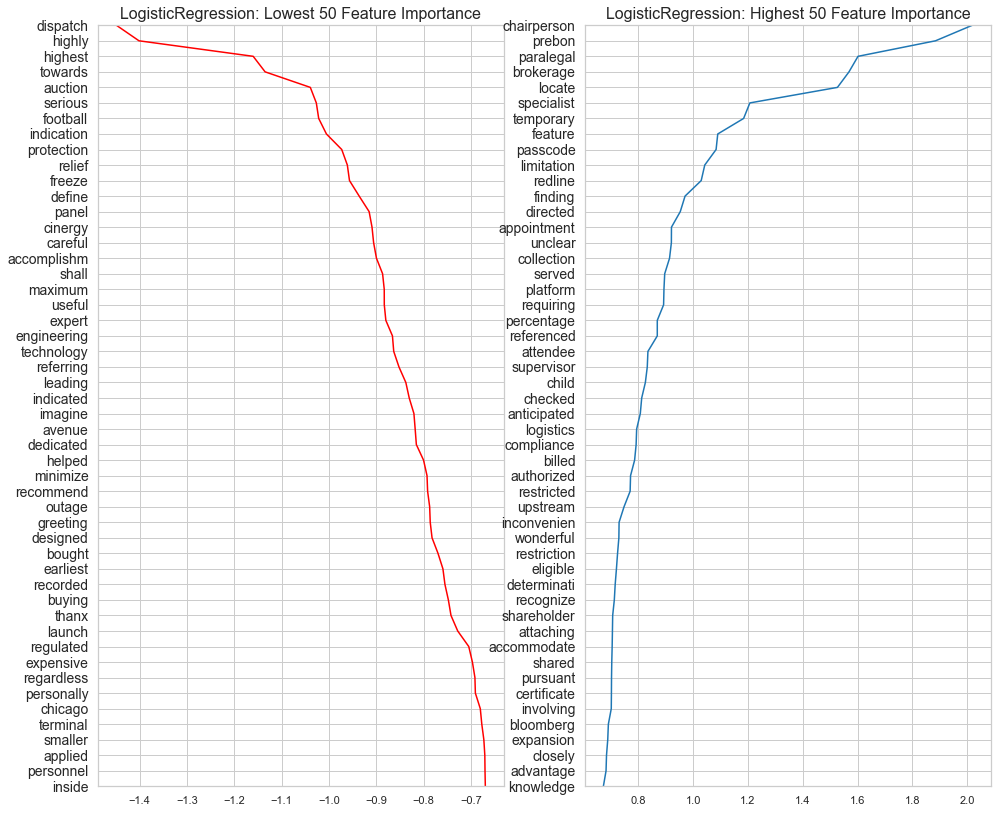


     feature_name  feature_coef  feature_frequency  character_count
270   chairperson      2.018544                 82               11
1221       prebon      1.884477                115                6
1148    paralegal      1.601634                 65                9
227     brokerage      1.568712                 87                9
955        locate      1.526571                 62                6
1561   specialist      1.207088                201               10
1648    temporary      1.184306                 79                9
671       feature      1.089935                 80                7
1159     passcode      1.083886                 80                8
946    limitation      1.042528                 78               10
1338      redline      1.029584                 81                7
689       finding      0.970653                105                7
505      directed      0.953184                 91                8
109   appointment      0.921080                

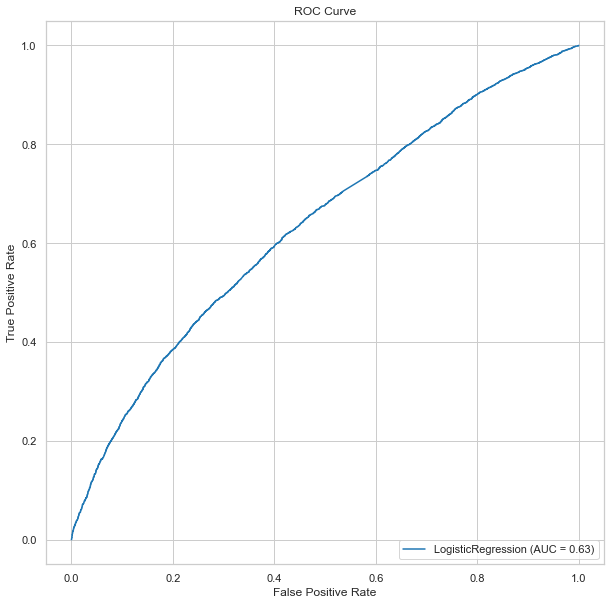

Wall time: 17.2 s


In [15]:
%%time
visualizer(df, n=40000, list_n=50, max_iter=1000, n_jobs=-1, min_df=50, max_df=.5, token_pattern=r"\w{5,11}", stop_words=None)

# End Section

In [16]:
end_time = time.perf_counter()
print('Run time: %.1fs (~%dm)' % ((end_time-start_time, (end_time-start_time)/60)))

Run time: 65.8s (~1m)
